In [1]:
#### -- 1-1. 모듈 불러오기 -- ####
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
# from torch.autograd import Variable

from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
#### -- 1-2. 분석 환경 설정 -- ####
# https://tutorials.pytorch.kr/recipes/recipes/save_load_across_devices.html
is_cuda = torch.cuda.is_available()
device = torch.device('cuda' if is_cuda else 'cpu') # gpu가 있으면 gpu 사용해줘
# device = torch.device('cpu')
print ('Current cuda device is', device)

Current cuda device is cuda


In [12]:
#### -- 1-3. Hyper-parameter 지정 -- ####
batch_size = 2
# 경사하강을 하는 과정의 폭을 크게, 작게 잡는 지에 따른 차이
# 100 10 1 0.1 0.01
learning_rate = 0.0001 
epoch_num = 15


In [4]:
#### -- 2-1. MNIST 데이터 불러오기 -- ####
# transform.ToTensor() 텐서로 데이터를 가져오자
train_data = datasets.MNIST(root = './data', train = True, download = True, transform = transforms.ToTensor())
test_data = datasets.MNIST(root = './data', train = False, transform = transforms.ToTensor())

print('number of training data: ', len(train_data))
print('number of test data: ', len(test_data))

100%|██████████| 9912422/9912422 [00:00<00:00, 35936889.80it/s]


Extracting ./data\MNIST\raw\train-images-idx3-ubyte.gz to ./data\MNIST\raw



100%|██████████| 28881/28881 [00:00<00:00, 28876208.30it/s]

Extracting ./data\MNIST\raw\train-labels-idx1-ubyte.gz to ./data\MNIST\raw



100%|██████████| 1648877/1648877 [00:00<00:00, 9813129.59it/s]


Extracting ./data\MNIST\raw\t10k-images-idx3-ubyte.gz to ./data\MNIST\raw



100%|██████████| 4542/4542 [00:00<?, ?it/s]

Extracting ./data\MNIST\raw\t10k-labels-idx1-ubyte.gz to ./data\MNIST\raw

number of training data:  60000
number of test data:  10000


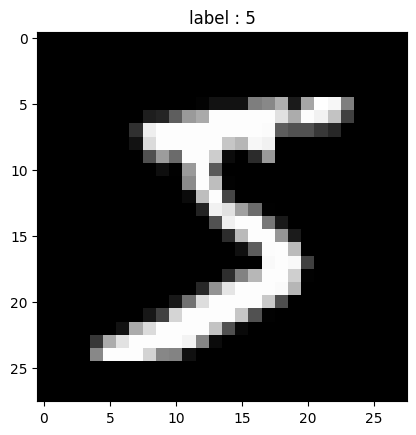

In [5]:
#### -- 2-2. MNIST 데이터 확인하기 -- ####
image, label = train_data[0]

# 텐서를 제거해서 이미지를 그리기
plt.imshow(image.squeeze().numpy(), cmap = 'gray')
plt.title('label : %s' % label)
plt.show()

In [6]:
# 이미지의 크기, 
# 차원축소 이미지의 크기, 
# 텐서를 넘파이화한 이미지의 크기, 
# 넘파이화 안한 이미지 크기
image, label = train_data[0]
image.shape, image.squeeze().shape, image.squeeze().numpy().shape, image.numpy().shape

(torch.Size([1, 28, 28]), torch.Size([28, 28]), (28, 28), (1, 28, 28))

In [7]:
### 내 폴더의 자료를 불러와서 x, y 데이터셋 구성하기
# https://tutorials.pytorch.kr/beginner/basics/data_tutorial.html
# https://pytorch.org/docs/stable/data.html
# 데이터셋은 샘플과 정답을 저장
# 데이터셋로더는 샘플에 쉽게 접근할 수있는 이터러블 객체로 감싼다


In [7]:
#### -- 2-3. Mini-Batch 구성하기 -- ####
train_loader = torch.utils.data.DataLoader(dataset = train_data, 
                                           batch_size = batch_size, shuffle = True)
test_loader  = torch.utils.data.DataLoader(dataset = test_data, 
                                           batch_size = batch_size, shuffle = True)

first_batch = train_loader.__iter__().__next__() # 첫번째 데이터 보자
print('{:15s} | {:<25s} | {}'.format('name', 'type', 'size'))
print('{:15s} | {:<25s} | {}'.format('Num of Batch', '', len(train_loader))) # 1200/50
print('{:15s} | {:<25s} | {}'.format('first_batch', str(type(first_batch)), len(first_batch))) # 데이터, 레이블
print('{:15s} | {:<25s} | {}'.format('first_batch[0]', str(type(first_batch[0])), first_batch[0].shape))
print('{:15s} | {:<25s} | {}'.format('first_batch[1]', str(type(first_batch[1])), first_batch[1].shape))

name            | type                      | size
Num of Batch    |                           | 1200
first_batch     | <class 'list'>            | 2
first_batch[0]  | <class 'torch.Tensor'>    | torch.Size([50, 1, 28, 28])
first_batch[1]  | <class 'torch.Tensor'>    | torch.Size([50])


tensor(3) torch.Size([1, 28, 28])
tensor(9) torch.Size([1, 28, 28])
tensor(1) torch.Size([1, 28, 28])
tensor(5) torch.Size([1, 28, 28])
tensor(1) torch.Size([1, 28, 28])


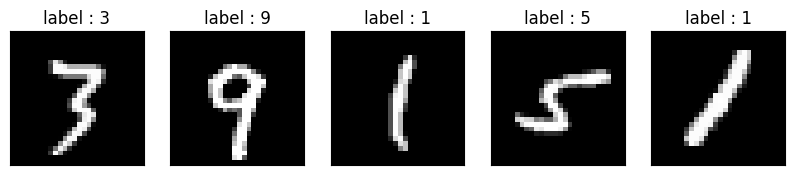

In [14]:
# 0에서 1로 구성되어 있는 자료
# 확인을 하지 않으면 스케일링을 잘못 적용할 수 있다
first_batch[0].min(), first_batch[0].max()

cnt = 0
plt.figure(figsize=(10,3))
for x, y in zip(first_batch[0][:5],first_batch[1][:5]):
    print(y, x.shape)
    cnt+=1
    plt.subplot(1,len(first_batch[0][:5]),cnt)
    plt.title('label : '+str(y.numpy())) # 'label: %s' %y.numpy()
    plt.xticks(ticks=[])
    plt.yticks(ticks=[])
    plt.imshow(x.squeeze().numpy(), cmap = 'gray')   
    

     
# plt.subplot 그리는 방법
# 1. 피그사이즈
# 2. 피그 서브플랏 정해주기 (시작숫자,마지막숫자,1번부터)
# 3. 타이틀, 틱 디테일 등 잡다한 거 넣어주기
# 3. 이미지쇼는 항상 마지막에 표기

In [10]:
#### -- 3-1. CNN 구조 설계하기 -- ####
# https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html

class CNN(nn.Module): # 상속
    def __init__(self): # 생성자
        # 부모 클래스인 nn.Module의 인스턴스를 리턴하고 생성자를 호출해서 초기화함
        super(CNN, self).__init__()
        
        self.conv1 = nn.Conv2d(1, 32, 3, 1) 
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout2d(0.25)
        self.dropout2 = nn.Dropout2d(0.5)
        self.fc1 = nn.Linear(9216, 128) # 
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        
        # x = torch.flatten(x, 1)
        # x = self.fc1(x)
        # x = F.relu(x)
        # x = self.dropout2(x)
        # x = self.fc2(x)
        # output = F.log_softmax(x, dim=1)
        return x

In [11]:
#### -- 3-2. Optimizer 및 손실함수 정의 -- ####

 # 클래스 호출해서 인스턴스 생성하고 디바이스에 넘기자
model = CNN().to(device)
# model.parameters는 위에 과정해서 만들어낸 웨이트 바이어스
optimizer = optim.Adam(model.parameters(), lr = learning_rate) 
# 손실함수
criterion = nn.CrossEntropyLoss() 

In [12]:
#### -- 3-3. 설계한 CNN 모형 확인하기 -- ####
print(model)

CNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (dropout1): Dropout2d(p=0.25, inplace=False)
  (dropout2): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=9216, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)


In [18]:
for data, target in train_loader:
    data = data.to(device)
    target = target.to(device)
    output = model(data)

torch.Size([50, 64, 12, 12])


RuntimeError: Can't call numpy() on Tensor that requires grad. Use tensor.detach().numpy() instead.

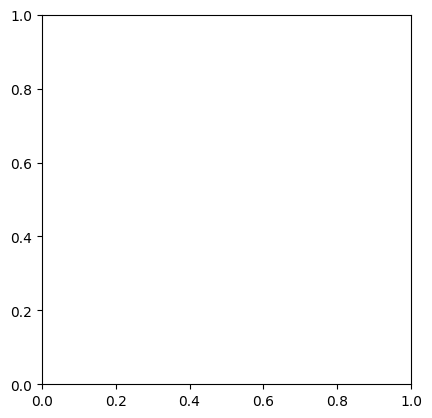

In [34]:
import numpy as np
print(np.shape(output))
plt.imshow(output[0][1].cpu())


In [13]:

#### -- 3-4. 모델 학습하기 -- ###
model.train()
i = 1 # 배치
preds = []
for epoch in range(epoch_num):
    for data, target in train_loader:
        data = data.to(device)
        target = target.to(device)
        optimizer.zero_grad() # 초기화
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        if i % 1000 == 0:
            print('Train Step: {}\tLoss: {:.3f}'.format(i, loss.item()))
            # 얼리스타핑 넣을 수 있다
        i += 1
        
    with torch.no_grad():
        for data, target in test_loader:
            data = data.to(device)
            targer=target.to(device)
            output = model(data)
            _, predictions = torch.max(output, 1)
            preds.append(predictions) 
        
'''
Train Step: 1000	Loss: 0.760
Train Step: 2000	Loss: 0.163
Train Step: 3000	Loss: 0.090
Train Step: 4000	Loss: 0.100
Train Step: 5000	Loss: 0.106
Train Step: 6000	Loss: 0.138
Train Step: 7000	Loss: 0.211
Train Step: 8000	Loss: 0.046
Train Step: 9000	Loss: 0.011
Train Step: 10000	Loss: 0.080
Train Step: 11000	Loss: 0.041
Train Step: 12000	Loss: 0.116
Train Step: 13000	Loss: 0.073
Train Step: 14000	Loss: 0.122
Train Step: 15000	Loss: 0.106
Train Step: 16000	Loss: 0.046
Train Step: 17000	Loss: 0.104
Train Step: 18000	Loss: 0.042 
-> 배치 1200 * 에포크 15, 트레인 데이터 60000 / 50 = 1200
'''

c:\Users\user\miniconda3\envs\gpu\lib\site-packages\torch\nn\functional.py:1331: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Train Step: 1000	Loss: 0.318
Train Step: 2000	Loss: 0.109
Train Step: 3000	Loss: 0.132
Train Step: 4000	Loss: 0.043
Train Step: 5000	Loss: 0.033
Train Step: 6000	Loss: 0.169
Train Step: 7000	Loss: 0.111
Train Step: 8000	Loss: 0.090
Train Step: 9000	Loss: 0.088
Train Step: 10000	Loss: 0.072
Train Step: 11000	Loss: 0.034
Train Step: 12000	Loss: 0.248
Train Step: 13000	Loss: 0.040
Train Step: 14000	Loss: 0.072
Train Step: 15000	Loss: 0.015
Train Step: 16000	Loss: 0.030
Train Step: 17000	Loss: 0.002
Train Step: 18000	Loss: 0.030


'\nTrain Step: 1000\tLoss: 0.760\nTrain Step: 2000\tLoss: 0.163\nTrain Step: 3000\tLoss: 0.090\nTrain Step: 4000\tLoss: 0.100\nTrain Step: 5000\tLoss: 0.106\nTrain Step: 6000\tLoss: 0.138\nTrain Step: 7000\tLoss: 0.211\nTrain Step: 8000\tLoss: 0.046\nTrain Step: 9000\tLoss: 0.011\nTrain Step: 10000\tLoss: 0.080\nTrain Step: 11000\tLoss: 0.041\nTrain Step: 12000\tLoss: 0.116\nTrain Step: 13000\tLoss: 0.073\nTrain Step: 14000\tLoss: 0.122\nTrain Step: 15000\tLoss: 0.106\nTrain Step: 16000\tLoss: 0.046\nTrain Step: 17000\tLoss: 0.104\nTrain Step: 18000\tLoss: 0.042 \n-> 배치 1200 * 에포크 15, 트레인 데이터 60000 / 50 = 1200\n'

In [ ]:
first_batch = train_loader.__iter__().__next__()  # 첫번째 데이터 보자

import numpy as np
model = CNN().to(device)
optimizer = optim.Adam(model.parameters(), lr = learning_rate)
criterion = nn.CrossEntropyLoss( )

data, target=first_batch

data = data.to(device)
target = target.to(device)
output = model(data)

output

In [14]:
# %pip install torchsummary

In [15]:
# import torchsummary
# torchsummary.summary(model,(1,28,28)) # 이미지 사이즈 잘 맞춰서 넣

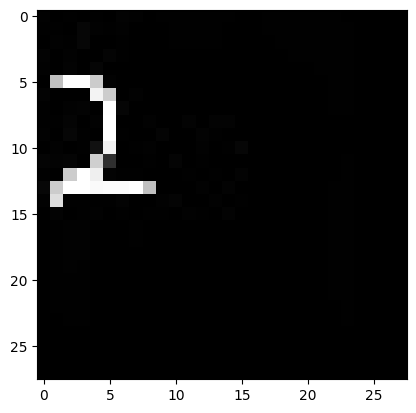

tensor([1], device='cuda:0')

In [39]:
import numpy as np
import cv2

img=cv2.imread('c:/data/mnist_img//num2.jpg', cv2.IMREAD_GRAYSCALE)
#print(img.shape)
#img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img=cv2.resize(img, (28,28))
#print(img.shape)
img=255-img # 배경 반전
img=img/255 # 정규화
plt.imshow(img, cmap='gray')
plt.show()
img=np.reshape(img,(1,1,28,28))
data = torch.Tensor(img)
data=data.to(device)
prediction=model(data)
result=torch.max(prediction,1)
result[1]

In [29]:
res = []
for x in range(5):
    a = []
    a.append([3,4,5])
    a.append([2,3,4])
    a.append([1,2,3])
    res.append(np.reshape(a,(-1)))

res

[array([3, 4, 5, 2, 3, 4, 1, 2, 3]),
 array([3, 4, 5, 2, 3, 4, 1, 2, 3]),
 array([3, 4, 5, 2, 3, 4, 1, 2, 3]),
 array([3, 4, 5, 2, 3, 4, 1, 2, 3]),
 array([3, 4, 5, 2, 3, 4, 1, 2, 3])]

In [36]:
a = []
a.append([])
a[-1].append(1)
a

[[1]]